In [1]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()

        # Contracting Path (Encoder)
        self.inc = DoubleConv(in_channels, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(256, 512))
        self.down4 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(512, 1024))

        # Expansive Path (Decoder)
        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(1024, 512)

        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(512, 256)

        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(256, 128)

        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv4 = DoubleConv(128, 64)

        # Final Convolution
        self.outc = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        # Decoder with skip connections
        up_x1 = self.up1(x5)
        # Handle potential size mismatch from pooling
        if up_x1.shape != x4.shape:
            up_x1 = TF.resize(up_x1, size=x4.shape[2:])
        concat1 = torch.cat([x4, up_x1], dim=1)
        dec_x1 = self.conv1(concat1)

        up_x2 = self.up2(dec_x1)
        if up_x2.shape != x3.shape:
            up_x2 = TF.resize(up_x2, size=x3.shape[2:])
        concat2 = torch.cat([x3, up_x2], dim=1)
        dec_x2 = self.conv2(concat2)

        up_x3 = self.up3(dec_x2)
        if up_x3.shape != x2.shape:
            up_x3 = TF.resize(up_x3, size=x2.shape[2:])
        concat3 = torch.cat([x2, up_x3], dim=1)
        dec_x3 = self.conv3(concat3)

        up_x4 = self.up4(dec_x3)
        if up_x4.shape != x1.shape:
            up_x4 = TF.resize(up_x4, size=x1.shape[2:])
        concat4 = torch.cat([x1, up_x4], dim=1)
        dec_x4 = self.conv4(concat4)

        # Final output
        logits = self.outc(dec_x4)
        return logits

Successfully downloaded image from URL.
Model loaded and in evaluation mode.
Making prediction...
Displaying results...


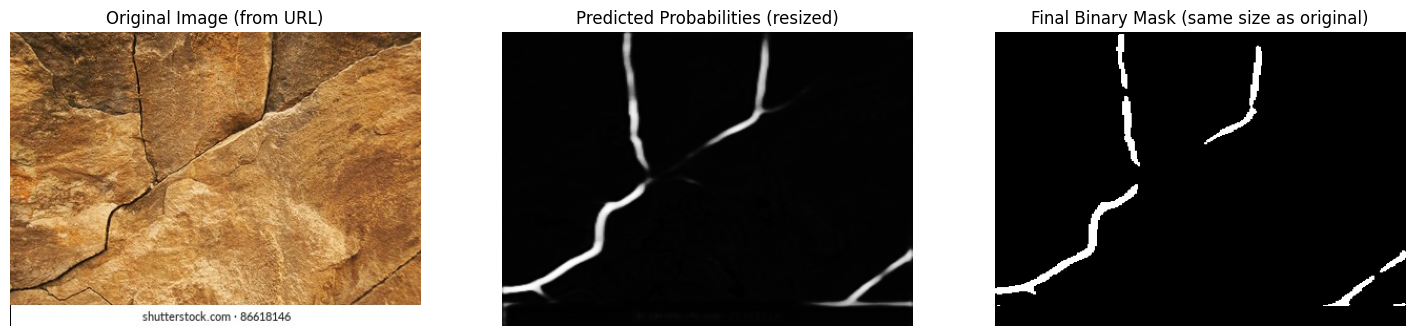

In [2]:
import torch
from PIL import Image
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import requests
import io

# --- Configuration ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_PATH = "/content/unet_model.pth"       # Path to your saved model

# URL of the fracture image you want to test
IMAGE_URL = "https://www.shutterstock.com/image-photo/fractured-cliff-surface-260nw-86618146.jpg" # Example X-ray image URL

# --- Step 1: Download the image from the URL ---

try:
    response = requests.get(IMAGE_URL)
    response.raise_for_status() # Raise an exception for bad status codes
    image_bytes = io.BytesIO(response.content)
    original_image = Image.open(image_bytes).convert("RGB")
    print(f"Successfully downloaded image from URL.")
except requests.exceptions.RequestException as e:
    print(f"Error downloading image: {e}")
    exit()

# --- Step 2: Load the trained model ---

# Make sure your UNet class definition is available
# from model import UNet

model = UNet(in_channels=3, out_channels=1)
model.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device(DEVICE)))
model.to(DEVICE)
model.eval()
print("Model loaded and in evaluation mode.")

# --- Step 3: Define transformations and preprocess the image ---

transform = A.Compose([
    A.Resize(height=256, width=256),
    A.Normalize(
        mean=[0.0, 0.0, 0.0],
        std=[1.0, 1.0, 1.0],
        max_pixel_value=255.0,
    ),
    ToTensorV2(),
])

image_np = np.array(original_image)
input_image = transform(image=image_np)["image"]
input_image = input_image.unsqueeze(0).to(DEVICE)

# --- Step 4: Make a prediction ---

print("Making prediction...")
with torch.no_grad():
    pred_logits = model(input_image)
    pred_probs = torch.sigmoid(pred_logits)
    pred_mask = (pred_probs > 0.5).float()

# --- Step 5: Visualize the results ---

output_probs = pred_probs.squeeze().cpu().numpy()
output_mask = pred_mask.squeeze().cpu().numpy()

# --- Step 6.5: Resize the mask back to original image size ---
import cv2

# Get original image size (width, height)
orig_w, orig_h = original_image.size

# Convert predicted mask tensor -> numpy
output_mask_resized = cv2.resize(output_mask, (orig_w, orig_h), interpolation=cv2.INTER_NEAREST)
output_probs_resized = cv2.resize(output_probs, (orig_w, orig_h), interpolation=cv2.INTER_LINEAR)

print("Displaying results...")
# --- Step 7: Visualize resized results ---

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

ax1.imshow(original_image)
ax1.set_title("Original Image (from URL)")
ax1.axis("off")

ax2.imshow(output_probs_resized, cmap='gray')
ax2.set_title("Predicted Probabilities")
ax2.axis("off")

ax3.imshow(output_mask_resized, cmap='gray')
ax3.set_title("Final Binary Mask")
ax3.axis("off")

plt.show()